<a href="https://colab.research.google.com/github/carlosmvond/bayes-curso/blob/main/Copia_de_MP_clase15octubre_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

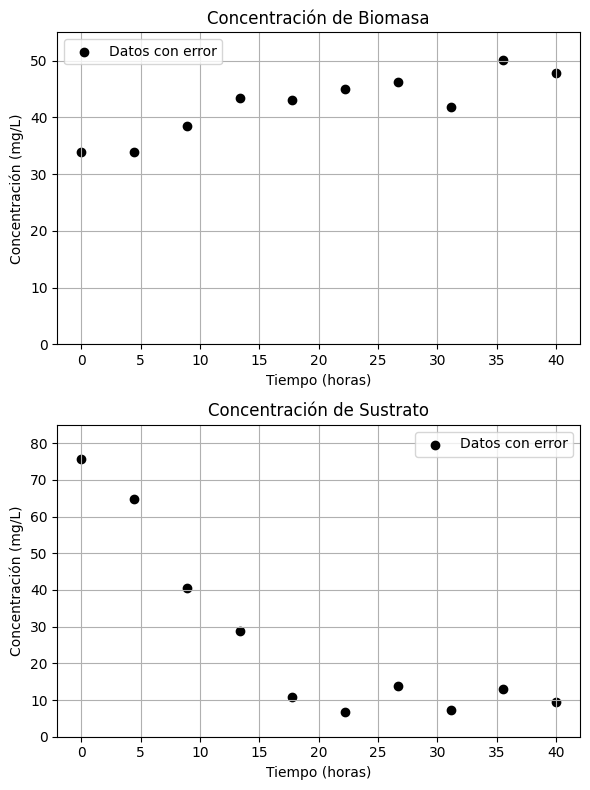

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parámetros
D = 0.1  # Tasa de dilución (1/horas)
S_in = 200  # Concentración de sustrato entrante (mg/L)
Y = 0.25  # Rendimiento celular

# P. aeruginosa
#mu_max = 0.14  # Tasa máxima de crecimiento (1/horas)
#K_s = 4.5  # Constante de saturación de Monod (mg/L)
# Condiciones iniciales
#X0 = 30  # Concentración inicial de biomasa (mg/L)
#S0 = 80  # Concentración inicial de sustrato (mg/L)


# Función que define las ecuaciones del modelo
def ode_model(t, y, mu_max, K_s):
    X, S = y
    mu = mu_max * S / (K_s + S)  # Tasa de crecimiento
    dXdt = X * (mu - D)           # Ecuación de crecimiento celular
    dSdt = D * (S_in - S) - mu * X / Y  # Ecuación de sustrato
    return [dXdt, dSdt]


t_data=np.array([ 0 ,  4.44444444,  8.88888889, 13.33333333, 17.77777778,
       22.22222222, 26.66666667, 31.11111111, 35.55555556, 40])

X_data=np.array([33.95121153, 33.81032247, 38.45771469, 43.42305625, 43.04599291,
       45.0127704 , 46.24676879, 41.86217356, 50.17064381, 47.83746726])

S_data=np.array([75.778712  , 64.91696237, 40.4583744 , 28.77872192, 10.74064748,
        6.61365065, 13.76734113,  7.29743887, 12.89774045,  9.57946694])


# Graficar los resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Gráfico de concentración de biomasa
#ax1.plot(t_eval, X, label='Biomasa (X)', color='blue', alpha=0.5)
ax1.scatter(t_data, X_data, color='black', marker='o', label='Datos con error')
ax1.set_xlabel('Tiempo (horas)')
ax1.set_ylabel('Concentración (mg/L)')
ax1.set_title('Concentración de Biomasa')
ax1.set_ylim(0, 55)  # Límite inferior y superior del eje y
ax1.legend()
ax1.grid()

# Gráfico de concentración de sustrato
#ax2.plot(t_eval, S, label='Sustrato (S)', color='orange', alpha=0.5)
ax2.scatter(t_data, S_data, color='black', marker='o', label='Datos con error')
ax2.set_xlabel('Tiempo (horas)')
ax2.set_ylabel('Concentración (mg/L)')
ax2.set_title('Concentración de Sustrato')
ax2.set_ylim(0, 85)  # Límite inferior y superior del eje y
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

#mu_max = 0.14  # Tasa máxima de crecimiento (1/horas)
#K_s = 4.5  # Constante de saturación de Monod (mg/L)
# Condiciones iniciales
#X0 = 30  # Concentración inicial de biomasa (mg/L)
#S0 = 80  # Concentración inicial de sustrato (mg/L)


t_span= (0, 41)

# PyMC Model for fitting
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    mu_max, K_s, x0, S0 = theta
    solution = solve_ivp(
        ode_model,
        t_span,
        [x0, S0],
        t_eval=t_data,
        args=(mu_max, K_s)
    )
    return solution.y.T


with pm.Model() as model:
    # Priors for the parameters that are independt of the batch
    K_s  =pm.Uniform("K_s", lower=0.1, upper=10)
    mu_max = pm.Uniform("mu_max", lower=0.05, upper=0.5)
    #Y =  pm.LogNormal("Y", mu=np.log(0.2), sigma=0.15)
    x0 =  pm.LogNormal("x0", mu=np.log(X_data[0]), sigma=0.1)
    S0 =  pm.LogNormal("S0", mu=np.log(S_data[0]), sigma=0.1)
    sigma =  pm.HalfNormal("sigma", sigma=5)

    theta = pm.math.stack([mu_max, K_s, x0, S0])

    ode_solution = pytensor_forward_model_matrix(theta)
    # Likelihood with noise
    pm.Normal("obs_X", mu=ode_solution[:, 0], sigma=sigma, observed=X_data)
    pm.Normal("obs_S", mu=ode_solution[:, 1], sigma=sigma, observed=S_data)


    # Specify the sampler and number of tuning/draw iterations
    tune =100
    draws = 100

    # Inference
    #step=pm.Metropolis()
    trace = pm.sample(tune=tune, draws=draws,  cores=2, target_accept=0.95)



summary = az.summary(trace, hdi_prob=0.95)
print(summary)

Output()

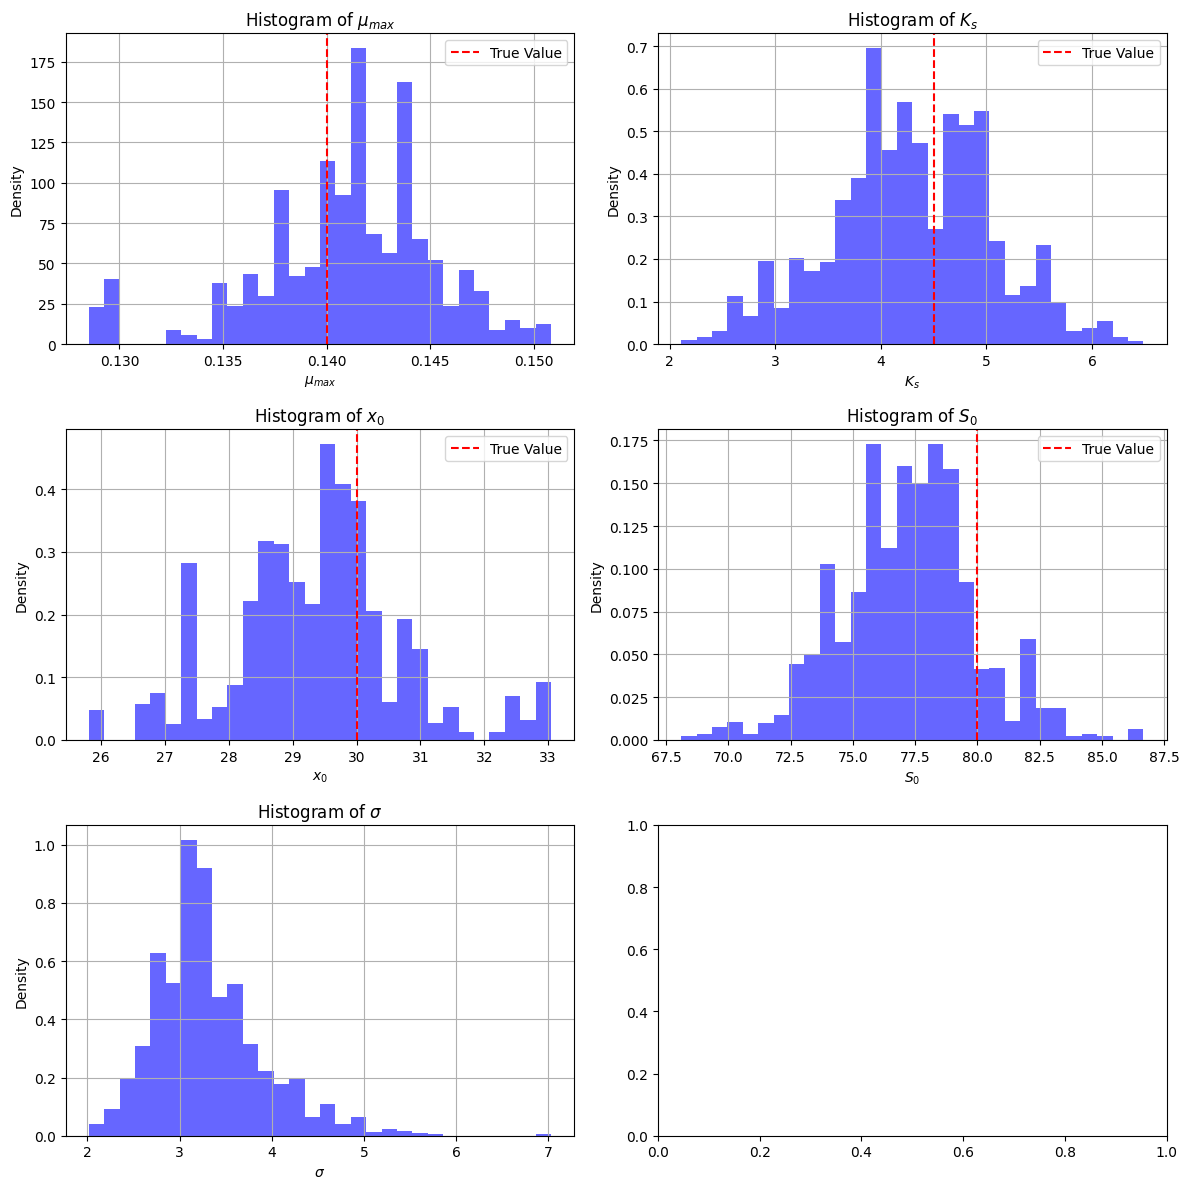

In [ ]:
import matplotlib.pyplot as plt

# Assuming posterior is defined and contains the samples
posterior = trace.posterior

mu_max_samples = posterior['mu_max'].values.flatten()
K_s_samples = posterior['K_s'].values.flatten()
x0_samples = posterior['x0'].values.flatten()
S0_samples = posterior['S0'].values.flatten()
sigma_samples = posterior['sigma'].values.flatten()

# Specified values
mu_max = 0.14  # Tasa máxima de crecimiento (1/horas)
K_s = 4.5      # Constante de saturación de Monod (mg/L)
X0 = 30        # Concentración inicial de biomasa (mg/L)
S0 = 80        # Concentración inicial de sustrato (mg/L)

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Plot histograms for each parameter
axs[0].hist(mu_max_samples, bins=30, density=True, alpha=0.6, color='b')
axs[0].set_title('Histogram of $\mu_{max}$')
axs[0].set_xlabel('$\mu_{max}$')
axs[0].set_ylabel('Density')
axs[0].grid()
axs[0].axvline(mu_max, color='red', linestyle='--', label='True Value')
axs[0].legend()

axs[1].hist(K_s_samples, bins=30, density=True, alpha=0.6, color='b')
axs[1].set_title('Histogram of $K_s$')
axs[1].set_xlabel('$K_s$')
axs[1].set_ylabel('Density')
axs[1].grid()
axs[1].axvline(K_s, color='red', linestyle='--', label='True Value')
axs[1].legend()

axs[2].hist(x0_samples, bins=30, density=True, alpha=0.6, color='b')
axs[2].set_title('Histogram of $x_0$')
axs[2].set_xlabel('$x_0$')
axs[2].set_ylabel('Density')
axs[2].grid()
axs[2].axvline(X0, color='red', linestyle='--', label='True Value')
axs[2].legend()

axs[3].hist(S0_samples, bins=30, density=True, alpha=0.6, color='b')
axs[3].set_title('Histogram of $S_0$')
axs[3].set_xlabel('$S_0$')
axs[3].set_ylabel('Density')
axs[3].grid()
axs[3].axvline(S0, color='red', linestyle='--', label='True Value')
axs[3].legend()

axs[4].hist(sigma_samples, bins=30, density=True, alpha=0.6, color='b')
axs[4].set_title('Histogram of $\sigma$')
axs[4].set_xlabel('$\sigma$')
axs[4].set_ylabel('Density')
axs[4].grid()
# Optional: Add a line for sigma if you have a true value
# axs[4].axvline(sigma_true_value, color='red', linestyle='--', label='True Value')
# axs[4].legend()

plt.tight_layout()
plt.show()





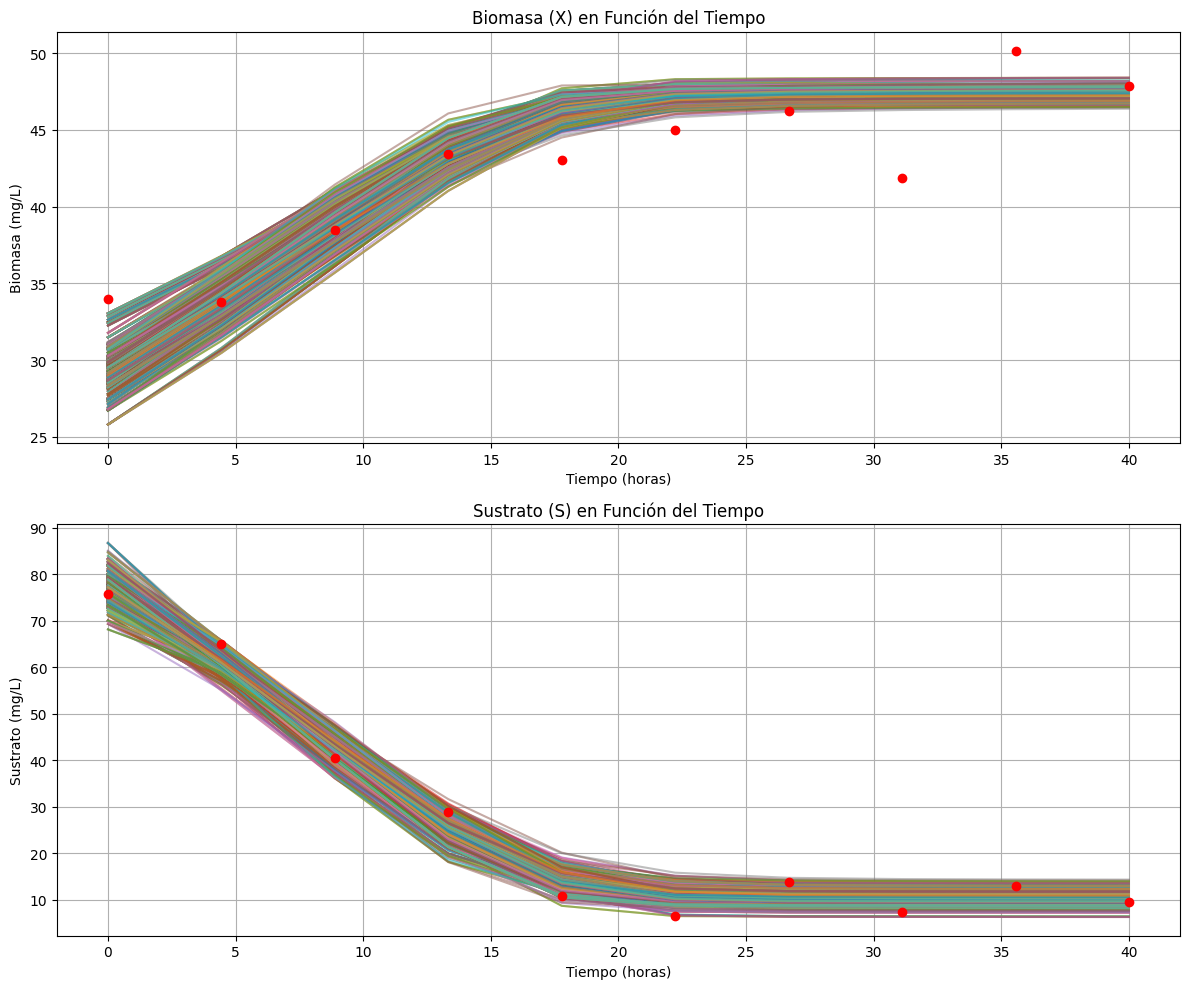

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Simulaciones
num_samples = len(mu_max_samples)
results = []

for i in range(num_samples):
    mu_max = mu_max_samples[i]
    K_s = K_s_samples[i]
    x0 = x0_samples[i]
    S0 = S0_samples[i]

    # Resolver el sistema de ecuaciones
    sol = solve_ivp(
        ode_model,
        [0, t_max],
        [x0, S0],
        t_eval=t_data,
        args=(mu_max, K_s)
    )

    results.append(sol.y)  # Guardar la solución (X, S) para cada muestra

# Convertir resultados a un arreglo numpy para facilitar el manejo
results = np.array(results)

# Graficar resultados en subgráficas
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico para Biomasa (X)
for i in range(num_samples):
    axs[0].plot(t_data, results[i, 0, :], alpha=0.5)  # Añadir transparencia
axs[0].scatter(t_data, X_data, color='red', label='Datos Observados', zorder=5)  # Datos observados
axs[0].set_title('Biomasa (X) en Función del Tiempo')
axs[0].set_xlabel('Tiempo (horas)')
axs[0].set_ylabel('Biomasa (mg/L)')
axs[0].grid()

# Gráfico para Sustrato (S)
for i in range(num_samples):
    axs[1].plot(t_data, results[i, 1, :], alpha=0.5)  # Añadir transparencia
axs[1].scatter(t_data, S_data, color='red', label='Datos Observados', zorder=5)  # Datos observados
axs[1].set_title('Sustrato (S) en Función del Tiempo')
axs[1].set_xlabel('Tiempo (horas)')
axs[1].set_ylabel('Sustrato (mg/L)')
axs[1].grid()

plt.tight_layout()
plt.show()


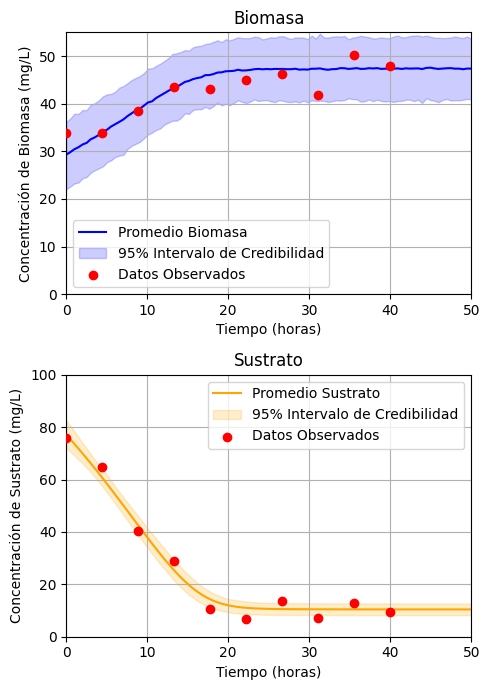

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definir el modelo de ODE
def ode_model(t, y, mu_max, K_s):
    X, S = y
    mu = mu_max * S / (K_s + S)  # Tasa de crecimiento
    dXdt = X * (mu - D)           # Ecuación de crecimiento celular
    dSdt = D * (S_in - S) - mu * X / Y  # Ecuación de sustrato
    return [dXdt, dSdt]

# Asumiendo que num_simulations está definido como la longitud de las muestras
num_simulations = len(mu_max_samples)  # Asegúrate de que esta variable esté definida

# Tiempo de simulación (horas)
t = np.linspace(0, 50, 100)  # 50 horas, 100 puntos

# Inicializar matrices para almacenar resultados
X_results = np.zeros((num_simulations, len(t)))
S_results = np.zeros((num_simulations, len(t)))

# Realizar simulaciones
for i in range(num_simulations):
    # Obtener valores para mu_max y K_s desde las muestras
    mu_max = mu_max_samples[i]
    K_s = K_s_samples[i]
    x0 = x0_samples[i]
    S0 = S0_samples[i]

    # Inicializar las condiciones iniciales
    y0 = [x0, S0]

    # Resolver el sistema de ecuaciones usando solve_ivp
    sol = solve_ivp(
        ode_model,
        [t[0], t[-1]],  # Intervalo de tiempo
        y0,
        t_eval=t,
        args=(mu_max, K_s)
    )

    # Almacenar los resultados en matrices
    X_results[i, :] = np.random.normal(loc=sol.y[0], scale=sigma_samples[i], size=len(sol.y[0]))
    S_results[i, :] = np.random.normal(loc=sol.y[1], scale=sigma_samples[i], size=len(sol.y[1]))

# Calcular el promedio y los intervalos de credibilidad del 95% para biomasa y sustrato
X_mean = np.mean(X_results, axis=0)
X_lower = np.percentile(X_results, 2.5, axis=0)
X_upper = np.percentile(X_results, 97.5, axis=0)

S_mean = np.mean(S_results, axis=0)
S_lower = np.percentile(S_results, 2.5, axis=0)
S_upper = np.percentile(S_results, 97.5, axis=0)

# Graficar los resultados

# Inicializar la figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7))

# Graficar el promedio y los intervalos de credibilidad para biomasa
ax1.plot(t, X_mean, color='blue', label='Promedio Biomasa')
ax1.fill_between(t, X_lower, X_upper, color='blue', alpha=0.2, label='95% Intervalo de Credibilidad')
ax1.scatter(t_data, X_data, color='red', label='Datos Observados', zorder=5)  # Scatter plot de datos observados
ax1.set_xlabel('Tiempo (horas)')
ax1.set_ylabel('Concentración de Biomasa (mg/L)')
ax1.set_title('Biomasa')
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 55)  # Límite inferior y superior del eje y
ax1.grid()
ax1.legend()

# Graficar el promedio y los intervalos de credibilidad para sustrato
ax2.plot(t, S_mean, color='orange', label='Promedio Sustrato')
ax2.fill_between(t, S_lower, S_upper, color='orange', alpha=0.2, label='95% Intervalo de Credibilidad')
ax2.scatter(t_data, S_data, color='red', label='Datos Observados', zorder=5)  # Scatter plot de datos observados
ax2.set_xlabel('Tiempo (horas)')
ax2.set_ylabel('Concentración de Sustrato (mg/L)')
ax2.set_title('Sustrato')
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 100)  # Límite inferior y superior del eje y
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()